[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AlejandroParedesLT/explainable_ai/blob/main/Explainable_Techniques_II.ipynb)

# Explainable Techniques II Dataset for prediction

This notebook provides a quick analysis to implement PDP, ICE, and ALE plots. To implement explainable techniques.

In [1]:
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import make_pipeline

from sklearn.inspection import partial_dependence
# from sklearn.inspection import plot_partial_dependence
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import fetch_california_housing

cal_housing = fetch_california_housing()
X = pd.DataFrame(cal_housing.data, columns=cal_housing.feature_names)
y = cal_housing.target

y -= y.mean()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,
                                                    random_state=0)

/usr/local/lib/python3.12/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:19: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


# Explainable AI analysis

### California Housing dataset


I will use the housing data from Berkeley University:

The target variable is:
median house value for California districts

With the independent variables being:

MedInc median income in block group

HouseAge median house age in block group

AveRooms average number of rooms per household

AveBedrms average number of bedrooms per household

Population block group population

AveOccup average number of household members

Latitude block group latitude

Longitude block group longitude


In [2]:
print("Training MLPRegressor...")
tic = time()
est = make_pipeline(QuantileTransformer(),
                    MLPRegressor(hidden_layer_sizes=(50, 50),
                                 learning_rate_init=0.01,
                                 early_stopping=True))
est.fit(X_train, y_train)
print("done in {:.3f}s".format(time() - tic))
print("Test R2 score: {:.2f}".format(est.score(X_test, y_test)))

Training MLPRegressor...
done in 19.857s
Test R2 score: 0.82


# Partial dependency Plots

- The variables of interest MedIncome, House age, average bedrooms and population are roughly linear, where the remainder variables are non-linear. Specifically Average rooms has a sigmoid-shaped function showing a high variability between 3 and 5. Household members (AveOccup) has a logaritmic scale.


- Shape of the features: Minc shows a positive slope growing with larger feature values. On the other hand hand House Age shows a near flat curve with a positive slope meaning that the variable has minimal effect on the dependent variable. Average rooms on the other hand shows a sigmoid-shaped function showing a plateu for lower end of the tail to the left and the tail to the right. Average Bedrooms and population have a very minimal positive slope reflecting low correlation and representation of the dependent variable. Finally average occupant reflects high variance of the dependent variable, showing a plateau shape for higher variables.

- The results seem to be coherent since very high Income is going to drive the price of the houses to higher values since rich families can invest in luxury items, which also explains the low variability of House age, the number of rooms and the number of people in the neighbourhood. Occupants also is very important since apartment complexes have lower price values whereas mansions where relatively few people often times are worth many times the value of an apartment.

Computing partial dependence plots...
done in 6.297s


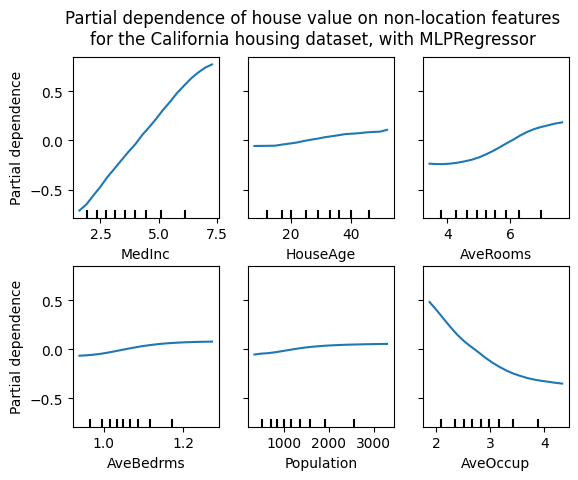

In [8]:
from sklearn.inspection import PartialDependenceDisplay

print('Computing partial dependence plots...')
tic = time()
# We don't compute the 2-way PDP (5, 1) here, because it is a lot slower
# with the brute method.
features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms',
 'Population', 'AveOccup']
PartialDependenceDisplay.from_estimator(est, X_train, features,
                        n_jobs=3, grid_resolution=20, kind='average') #, kind='average') #, kind='both')
print("done in {:.3f}s".format(time() - tic))
fig = plt.gcf()
fig.suptitle('Partial dependence of house value on non-location features\n'
             'for the California housing dataset, with MLPRegressor')
fig.subplots_adjust(hspace=0.3)

## ICE Plots

Median Income: houses in higher-income neighborhoods are predicted to be worth more. Effect of income is not uniform across all samples


HouseAge: The curve is relatively flat with mild variation → model doesn't see strong predictive value from housing age. Some ICE curves diverge, suggesting age might matter in certain subgroups.


AveRooms: More rooms tends to increase predicted house value. Large room counts in very dense areas may behave differently.

Average Bedrooms per Household: no clear effects

Population: no clear effects


AveOccup Slight negative slope → larger households predict lower house values.Effect is subtle and heterogeneous for larger values.

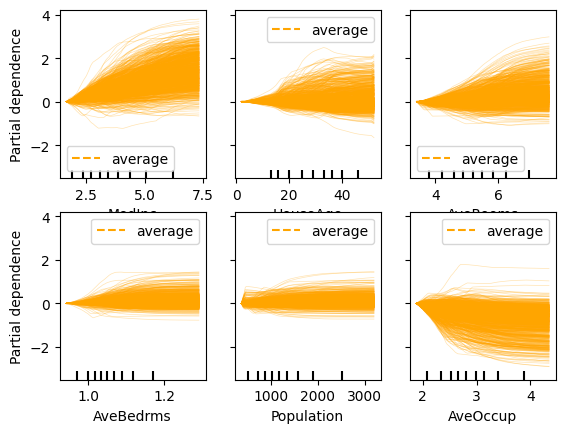

In [12]:
# Choose the feature of interest
features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms',
 'Population', 'AveOccup']

PartialDependenceDisplay.from_estimator(
    est,
    X_test,
    features,
    kind='both',
    centered=True,
    line_kw={"color": "orange"}
)

# ALE Plot

Shown below median income is the most important feature. Shows a clear positive slope with a break at median income this behavior is relatively consistent across all groups.

House age has an increasing effect between 20 to 30 (incrementing the value of the property and then minimal effect on the price between 30 and 45 and then minimal increase in value.

Average rooms below 5 have a negative effect on the median price. Then a very important increase between 5 and 7 and then a minimal slope for upper values. Overall the effect is not very important.


Average bedrooms has a spike around 1 (I am guessing this is relative to a studio apartment?) then there is a minimal positive slope.

Population between 500 and 1500 have a positive slope considering more populated areas having a higher price.

The Average occupants in the household has a negative effect given larger variables.

In [5]:
!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython
!pip install scipy==1.13.1

  Cloning https://github.com/MaximeJumelle/ALEPython.git (to revision dev) to /tmp/pip-install-q6veg0q2/alepython_ac03c150625f45eba1bed46ed85b5080
  Running command git clone --filter=blob:none --quiet https://github.com/MaximeJumelle/ALEPython.git /tmp/pip-install-q6veg0q2/alepython_ac03c150625f45eba1bed46ed85b5080
  Resolved https://github.com/MaximeJumelle/ALEPython.git to commit 286350ab674980a32270db2a0b5ccca1380312a7
  Preparing metadata (setup.py) ... done


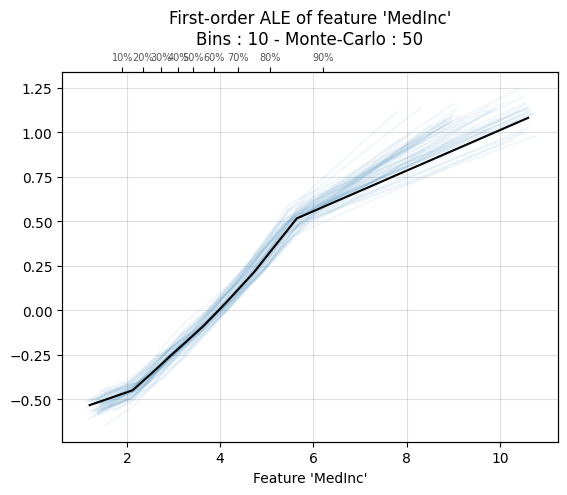

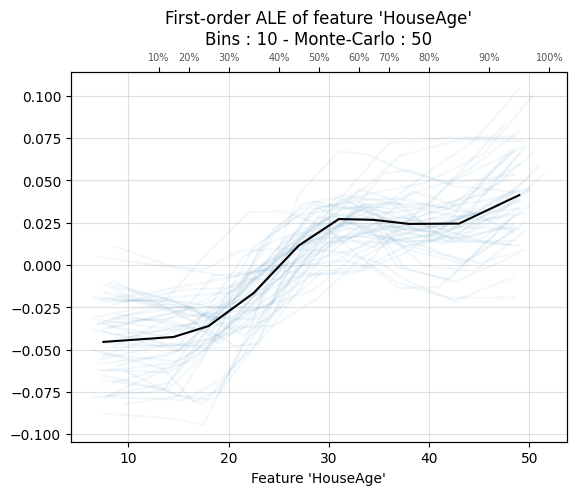

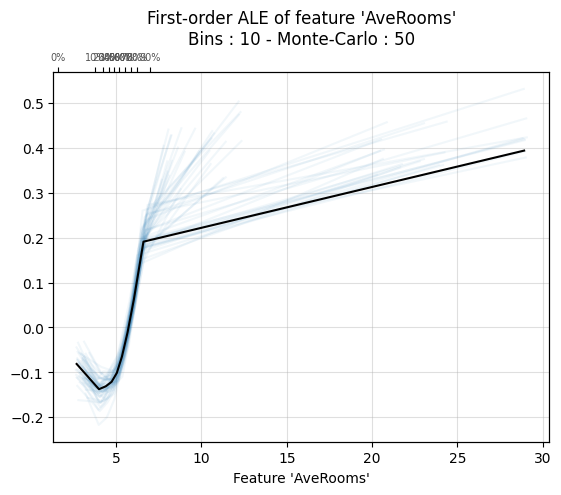

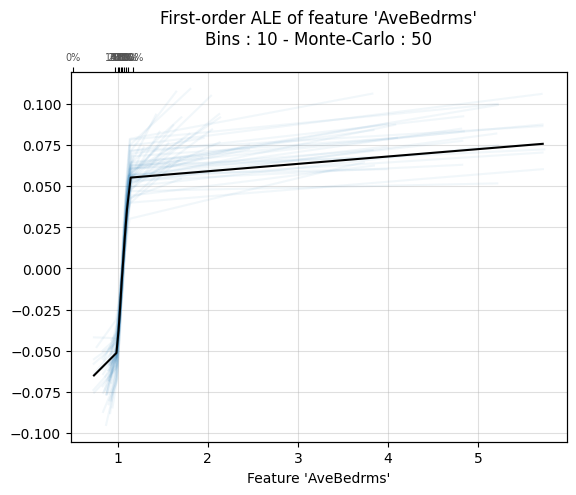

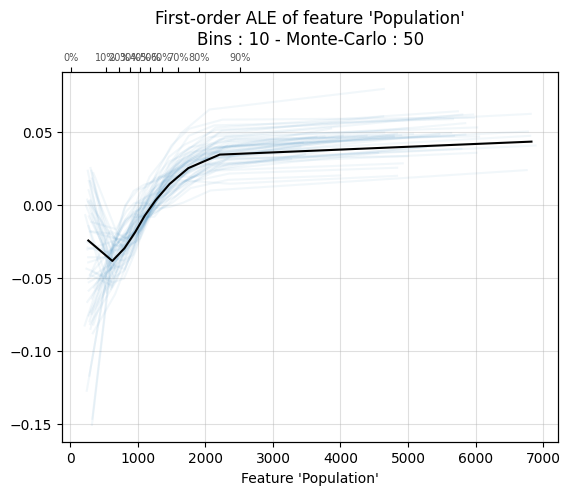

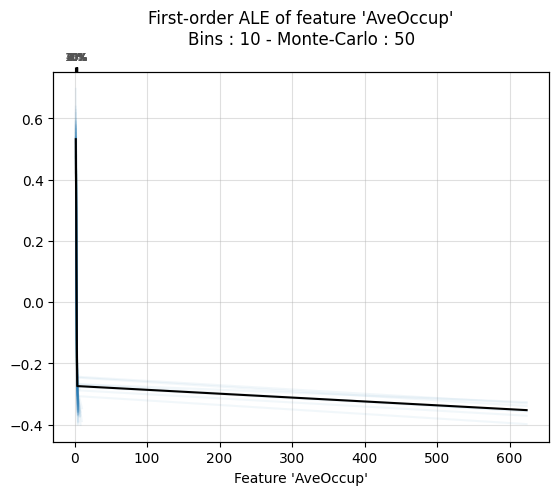

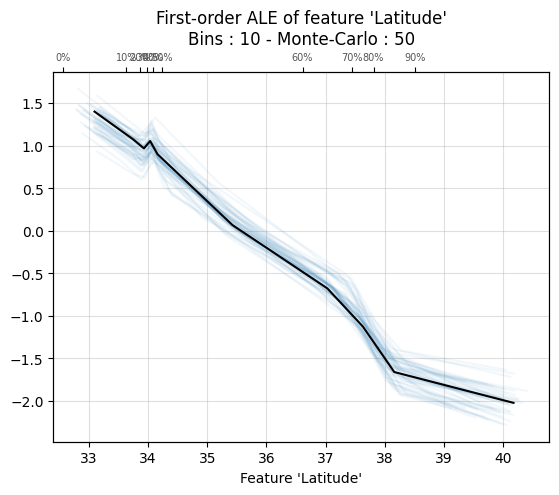

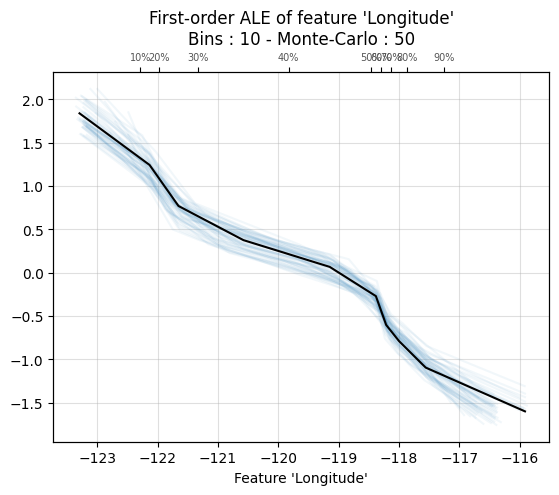

In [6]:
from alepython import ale_plot

features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms',
 'Population', 'AveOccup', 'Latitude', 'Longitude']

for feature in features:
    ale_plot(est, X_test, feature, monte_carlo=True)


The second-order ALE of features MedInc and House age is shown below the region above 6 for Median income and above 25 represent a negative relationship, whereas the quadrant for House age below 25 represent a strong negative correlation in the outcome. For other examples such as second order ALE establishing the connection between House Age and Average Rooms we have a positive correlation between House Age>30 and Average rooms>7.

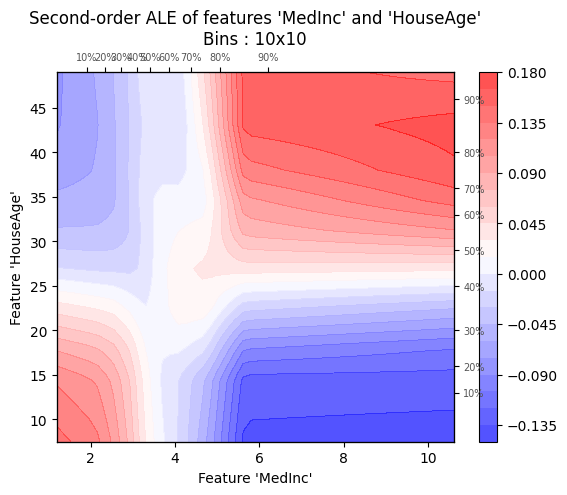

<Axes: title={'center': "Second-order ALE of features 'MedInc' and 'HouseAge'\nBins : 10x10"}, xlabel="Feature 'MedInc'", ylabel="Feature 'HouseAge'">

In [7]:
# 2D Second-Order ALE Plot
ale_plot(est, X_test, X_test.columns[:2], bins=10)

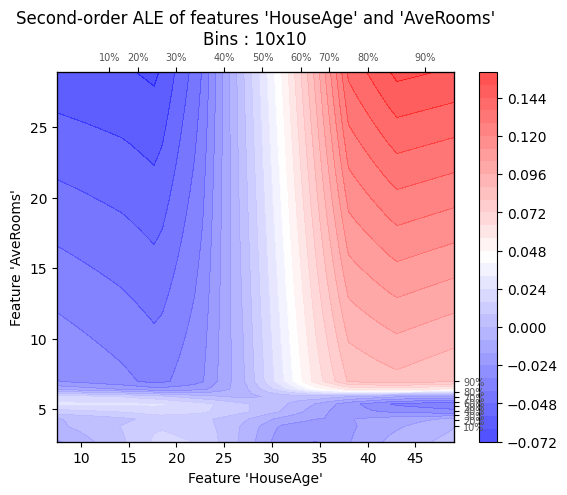

<Axes: title={'center': "Second-order ALE of features 'HouseAge' and 'AveRooms'\nBins : 10x10"}, xlabel="Feature 'HouseAge'", ylabel="Feature 'AveRooms'">

In [13]:
# 2D Second-Order ALE Plot
ale_plot(est, X_test, X_test.columns[1:3], bins=10)

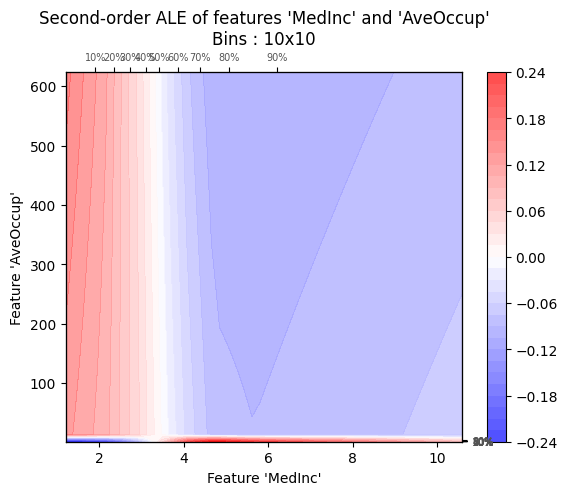

<Axes: title={'center': "Second-order ALE of features 'MedInc' and 'AveOccup'\nBins : 10x10"}, xlabel="Feature 'MedInc'", ylabel="Feature 'AveOccup'">

In [19]:
# 2D Second-Order ALE Plot
ale_plot(est, X_test, [X_test.columns[0],X_test.columns[5]], bins=10)